# This is the python script to Goal B) of the thesis
It reloads the pre-processed images and performs various ways to do edge detection of the image. We test the algorithms with different inputs. Image blurring usually helps to perform best at edge detection. The detected lineaments (x1,y1,x2,y2 - coordinates) are then stored in .csv - files and are exported to drive. The lineaments build the input for the data analysis in Goal C).

In [86]:
#from google.colab import drive
#drive.mount('/content/drive')

Load libraries

In [87]:
import numpy as np
import pandas as pd
#from pandas.plotting import table
import cv2 as cv
#import math
import scipy.stats as stats
from scipy.stats import norm
#import seaborn as sns


from google.colab.patches import cv2_imshow # for image display
from skimage import io
import csv
from PIL import Image 
import matplotlib.pylab as plt
from matplotlib.pyplot import imshow
import matplotlib.image as mpimg 
from matplotlib import colors

from PIL import Image
import urllib.request
import zipfile

In [88]:
import tensorflow as tf

from scipy.ndimage import rotate

# We'll tell matplotlib to inline any drawn figures like so:

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Load input images and the pre-processed version of them

In [89]:
#############
# Hillshade MONO directional
url_hillshade_Mono = 'https://github.com/stfabbri/CAS_ADS_Thesis_final/blob/main/INPUT_FIGURES/Hillsh_315_45_1_2400px.tif?raw=true'

with urllib.request.urlopen(url_hillshade_Mono) as url:
  with open('Hillsh_315_45_1_2400px.tif', 'wb') as f:
    f.write(url.read())
# Assign Name
Hillsh_Mono = mpimg.imread('Hillsh_315_45_1_2400px.tif')

#############
# Hillshade MULTI directional
url_hillshade_Multi = 'https://github.com/stfabbri/CAS_ADS_Thesis_final/blob/main/INPUT_FIGURES/Hillsh_Multi_2400px.tif?raw=true'
with urllib.request.urlopen(url_hillshade_Multi) as url:
    with open('Hillsh_Multi_2400px.tif', 'wb') as f:
        f.write(url.read())
# Assign Name
Hillsh_Multi = mpimg.imread('Hillsh_Multi_2400px.tif')


################
# Orthophoto
url_Ortho = 'https://github.com/stfabbri/CAS_ADS_Thesis_final/blob/main/INPUT_FIGURES/10_Ortho_2400pixels.tif?raw=true'
with urllib.request.urlopen(url_Ortho) as url:
    with open('10_Ortho_2400pixels.tif', 'wb') as f:
        f.write(url.read())
# Assign Name
Ortho = mpimg.imread('10_Ortho_2400pixels.tif')

#############
# Digital elevation model (dem)
url_dem = 'https://github.com/stfabbri/CAS_ADS_Thesis_final/blob/main/INPUT_FIGURES/DEM_10.zip?raw=true'
dem = pd.read_csv(url_dem,compression='zip',header=None, delimiter=';', dtype= 'float64')
df_dem = pd.DataFrame(dem)
cmap   = 'gist_earth'

############
# Load contrast enhanced image
url_out = 'https://github.com/stfabbri/CAS_ADS_Thesis_final/blob/main/INPUT_FIGURES/out.tif?raw=true'
with urllib.request.urlopen(url_out) as url:
    with open('out.tif', 'wb') as f:
        f.write(url.read())

# WITH CONTRAST
ortho_contrast = mpimg.imread('out.tif')

# WHEN LOADING FROM GOOGLE DRIVE
#Hillsh_Multi = mpimg.imread('/content/drive/MyDrive/Final_project_ADS/Hillsh_Multi_2400px.tif') # JPEG required, otherwise no color channels. Jpeg = uint8, png = float32 -> Problem
#Hillsh_Mono = mpimg.imread('/content/drive/MyDrive/Final_project_ADS/Hillsh_315_45_1_2400px.tif') # JPEG required, otherwise no color channels. Jpeg = uint8, png = float32 -> Problem
#Ortho = mpimg.imread('/content/drive/MyDrive/Final_project_ADS/10_Ortho_2400pixels.tif') # JPEG/TIF required, otherwise no color channels. Jpeg = uint8, png = float32 -> Problem
#ortho_contrast = mpimg.imread('/content/drive/MyDrive/Final_project_ADS/out.tif')

gray_image_contrast = cv.cvtColor(ortho_contrast, cv.COLOR_BGR2GRAY)
inv_gray_contrast = 255 - gray_image_contrast
inv_gray_contrast_imBlur5 = cv.blur(inv_gray_contrast,(5,5))

# Blur the image for better edge detection
#GaussianBlur(src, ksize, sigmaX[, dst[, sigmaY[, borderType]]]) -> dst
## Normal ortho image blurred
ortho_contrast_Blur55 = cv.GaussianBlur(ortho_contrast,(5,5),5)
ortho_contrast_Blur99 = cv.GaussianBlur(ortho_contrast,(9,9),5)
ortho_contrast_Blur1515 = cv.GaussianBlur(ortho_contrast,(15,15),5)
## Inverse image blurred
im_Blur55 = cv.GaussianBlur(inv_gray_contrast,(5,5),5)
im_Blur99 = cv.GaussianBlur(inv_gray_contrast,(9,9),5)
im_Blur1515 = cv.GaussianBlur(inv_gray_contrast,(15,15),5)
im_Blur2121 = cv.GaussianBlur(inv_gray_contrast,(21,21),5)

ortho_contrast_Blur55 = cv.GaussianBlur(ortho_contrast,(5,5),5)
ortho_contrast_Blur99 = cv.GaussianBlur(ortho_contrast,(9,9),5)
ortho_contrast_Blur1515 = cv.GaussianBlur(ortho_contrast,(15,15),5)

# Ortho Image blurred
ortho_contrast_Blur55 = cv.GaussianBlur(ortho_contrast,(5,5),5)
ortho_contrast_Blur99 = cv.GaussianBlur(ortho_contrast,(9,9),5)
ortho_contrast_Blur1515 = cv.GaussianBlur(ortho_contrast,(15,15),5)

# Multidirectional Hillshade blurred
im_Blur1515_Multi = cv.GaussianBlur(Hillsh_Multi,(15,15),5)
im_Blur2121_Multi = cv.GaussianBlur(Hillsh_Multi,(21,21),7)

## First attempt of edge detection with convolutional model & various filter testing

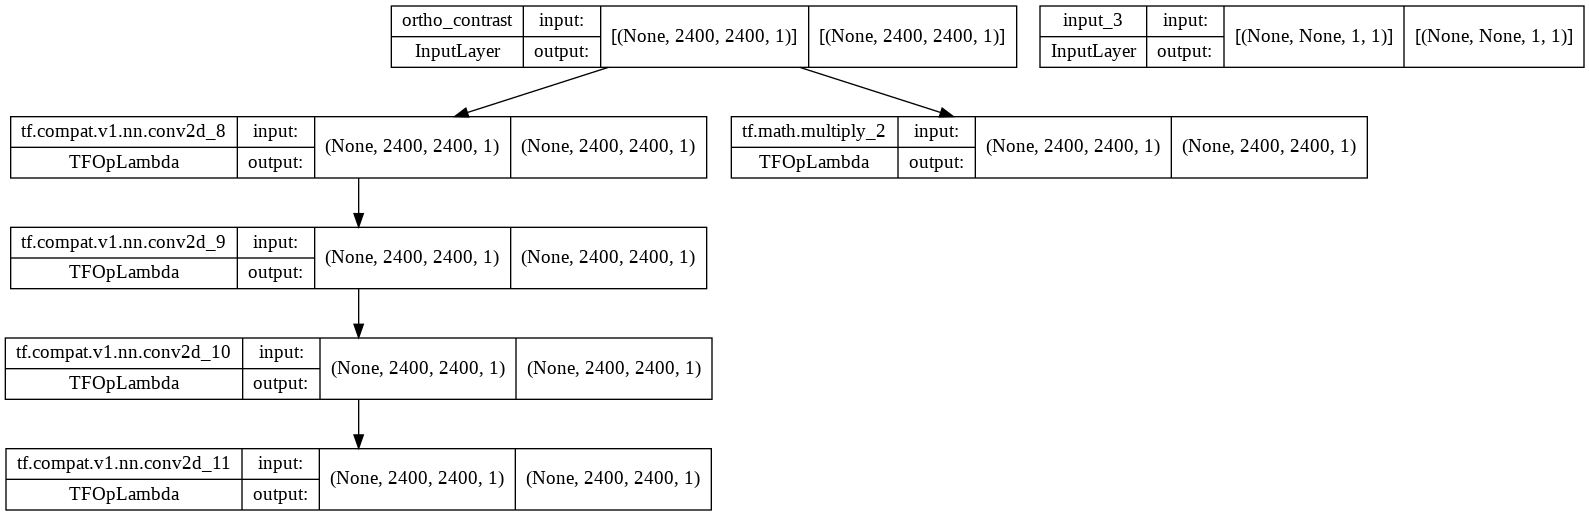

In [90]:
# (Modified from Tutorial IV, Mykhailo Vladymyrov)
# 1 channel: greyscale image 
ortho_contrast = plt.imread('out.tif').mean(axis=2)[0:2400, 0:2400].astype(np.float32)

x = tf.keras.layers.Input(dtype=tf.float32, shape=(2400,2400,1),name='ortho_contrast')

# Build the convolutional filter:
# shape means height of filter = None, width of filter = None, number input channels, number output channels

flt = tf.keras.layers.Input(dtype=tf.float32, shape=(None,None,1,1), name='flt')[0]

stride = 1 # Whether we should downsize the sample when applying the filter
dilation = 1

padding = 'SAME'

# Build four convolutional layers
y1 = tf.nn.conv2d(x , flt, strides=[1,stride,stride,1], dilations=[1,dilation,dilation,1], padding=padding, name='y1')
y2 = tf.nn.conv2d(y1, flt, strides=[1,stride,stride,1], dilations=[1,dilation,dilation,1], padding=padding, name='y2')
y3 = tf.nn.conv2d(y2, flt, strides=[1,stride,stride,1], dilations=[1,dilation,dilation,1], padding=padding, name='y3')
y4 = tf.nn.conv2d(y3, flt, strides=[1,stride,stride,1], dilations=[1,dilation,dilation,1], padding=padding, name='y4')

# Note flt 
model = tf.keras.Model(inputs=[x, flt], outputs=[x*1, y1, y2, y3, y4])

tf.keras.utils.plot_model(model, show_shapes=True)

# summarize model
#model.summary()

In [91]:
# Transform dimensions to work with images
def get_convolved(img, flt):
  img_raw4d = img[np.newaxis,...,np.newaxis]
  
  flt_mtx_np = np.array(flt_mtx, np.float32)
  flt_mtx_np = flt_mtx_np[..., np.newaxis, np.newaxis]

  res = model((img_raw4d, flt_mtx_np))
  res = [r[0,...,0].numpy() for r in res]

  return res

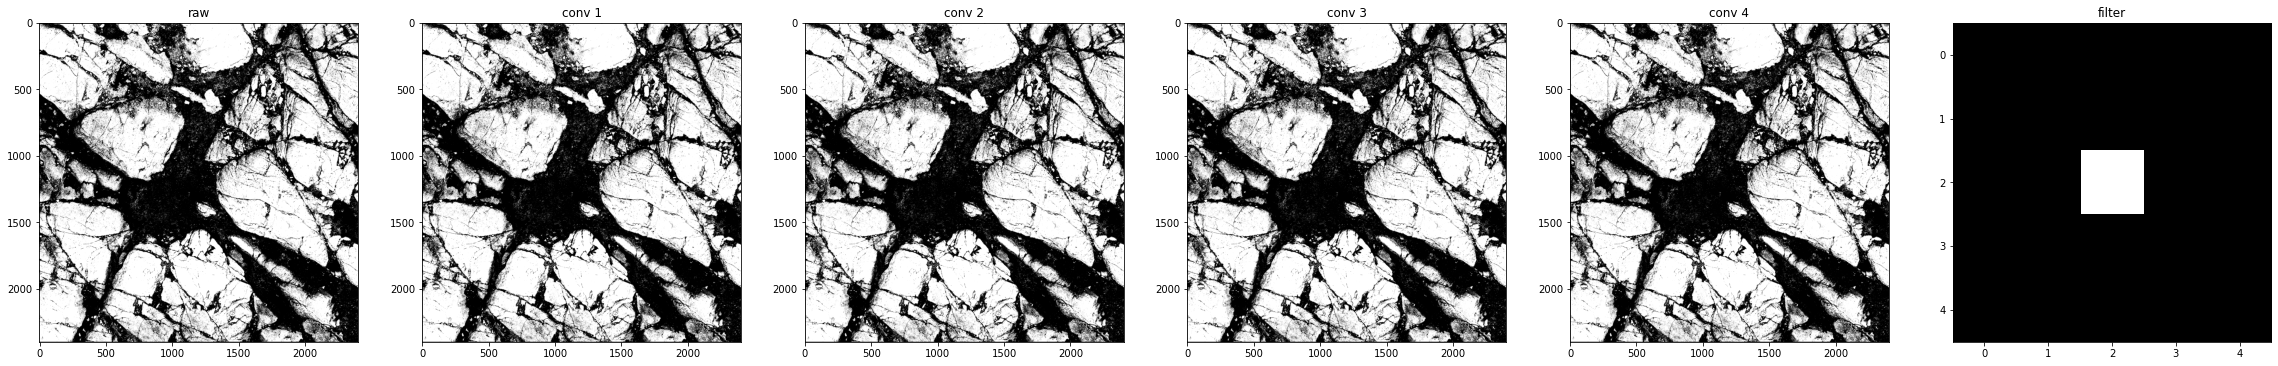

In [92]:
flt_mtx = [
    [ 0, 0, 0, 0, 0,],
    [ 0, 0, 0, 0, 0,],
    [ 0, 0, 1, 0, 0,],
    [ 0, 0, 0, 0, 0,],
    [ 0, 0, 0, 0, 0,],
] # identity transformation

# Pass flt_mtx as second input parameter to model through get_convolved
ims_convolves = get_convolved(ortho_contrast, flt_mtx)

n = len(ims_convolves)
fig, ax = plt.subplots(1, n+1, figsize=(n*8, 8))
for col in range(n):
    ax[col].imshow(ims_convolves[col], cmap='gray')  #, vmin=-3, vmax=3
    ax[col].grid(False)
    ax[col].set_title('conv %d'% col if col else 'raw')

ax[n].imshow(flt_mtx, cmap='gray')
ax[n].grid(False)
_=ax[n].set_title('filter')

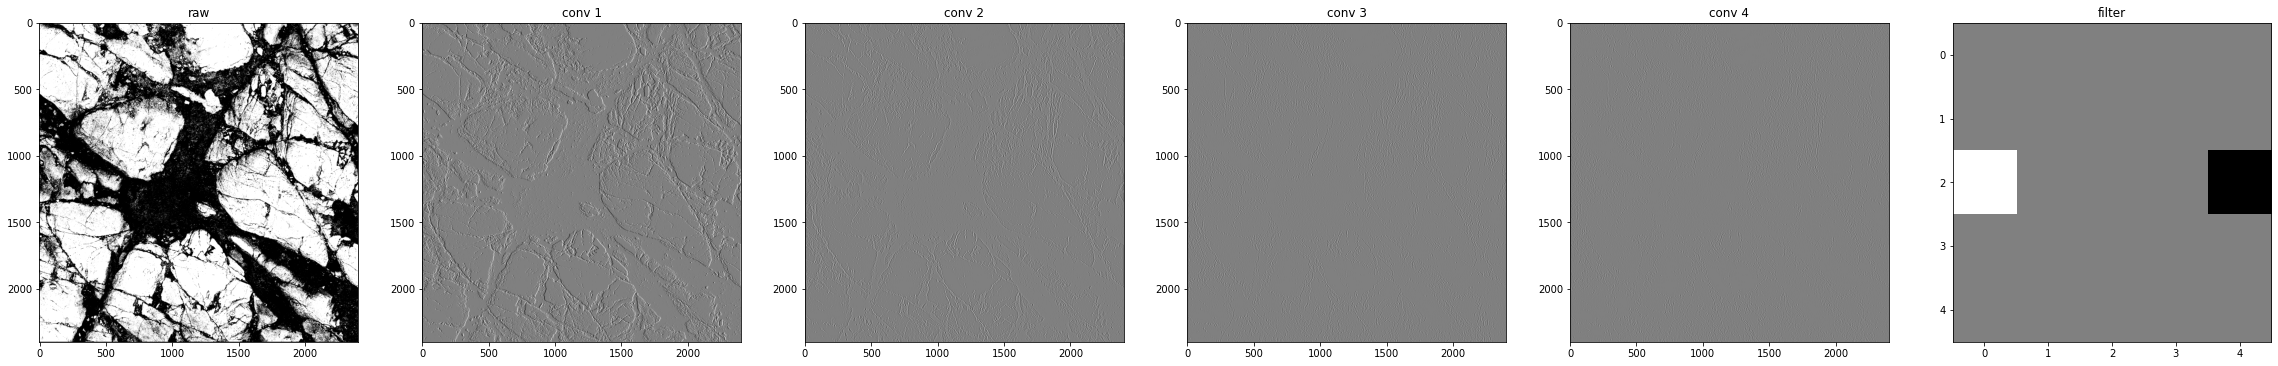

In [93]:
# The following detects high gradients, finding edges = big change of values
flt_mtx = [
    [ 0, 0, 0, 0, 0,],
    [ 0, 0, 0, 0, 0,],
    [ 1, 0, 0, 0, -1,],
    [ 0, 0, 0, 0, 0,],
    [ 0, 0, 0, 0, 0,],
] # identity transformation

# Pass flt_mtx as second input parameter to model through get_convolved
ims_convolves = get_convolved(ortho_contrast, flt_mtx)

n = len(ims_convolves)
fig, ax = plt.subplots(1, n+1, figsize=(n*8, 8))
for col in range(n):
    ax[col].imshow(ims_convolves[col], cmap='gray')  #, vmin=-3, vmax=3
    ax[col].grid(False)
    ax[col].set_title('conv %d'% col if col else 'raw')

ax[n].imshow(flt_mtx, cmap='gray')
ax[n].grid(False)
_=ax[n].set_title('filter')

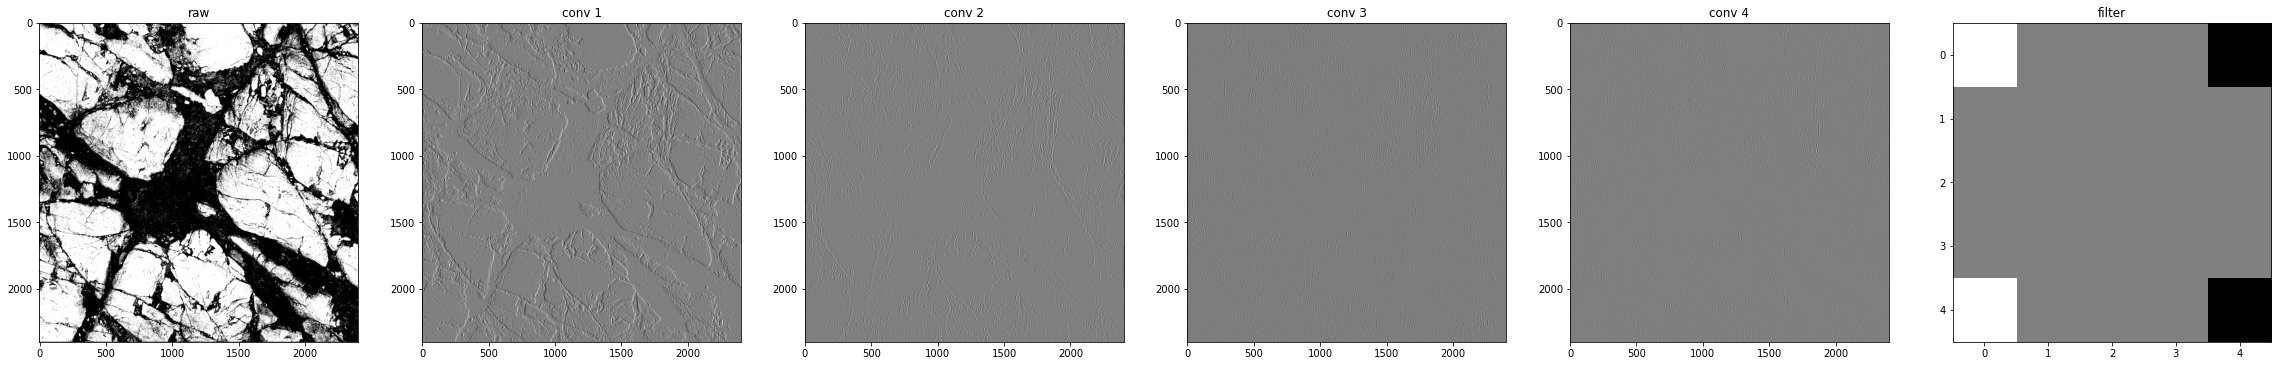

In [94]:
# Edges along 45 degrees
flt_mtx = [
    [ 1, 0, 0, 0, -1,],
    [ 0, 0, 0, 0, 0,],
    [ 0, 0, 0, 0, 0,],
    [ 0, 0, 0, 0, 0,],
    [ 1, 0, 0, 0, -1,],
] # identity transformation

# Pass flt_mtx as second input parameter to model through get_convolved
ims_convolves = get_convolved(ortho_contrast, flt_mtx)

n = len(ims_convolves)
fig, ax = plt.subplots(1, n+1, figsize=(n*8, 8))
for col in range(n):
    ax[col].imshow(ims_convolves[col], cmap='gray')  #, vmin=-3, vmax=3
    ax[col].grid(False)
    ax[col].set_title('conv %d'% col if col else 'raw')

ax[n].imshow(flt_mtx, cmap='gray')
ax[n].grid(False)
_=ax[n].set_title('filter')

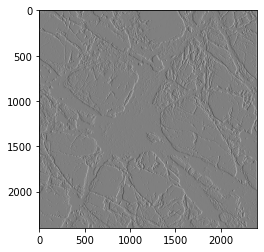

In [95]:
imshow(ims_convolves[1],  cmap='gray')

# Another way to detect edges via SOBEL

([<matplotlib.axis.YTick at 0x7f761aaade90>,
 <a list of 5 Text major ticklabel objects>)

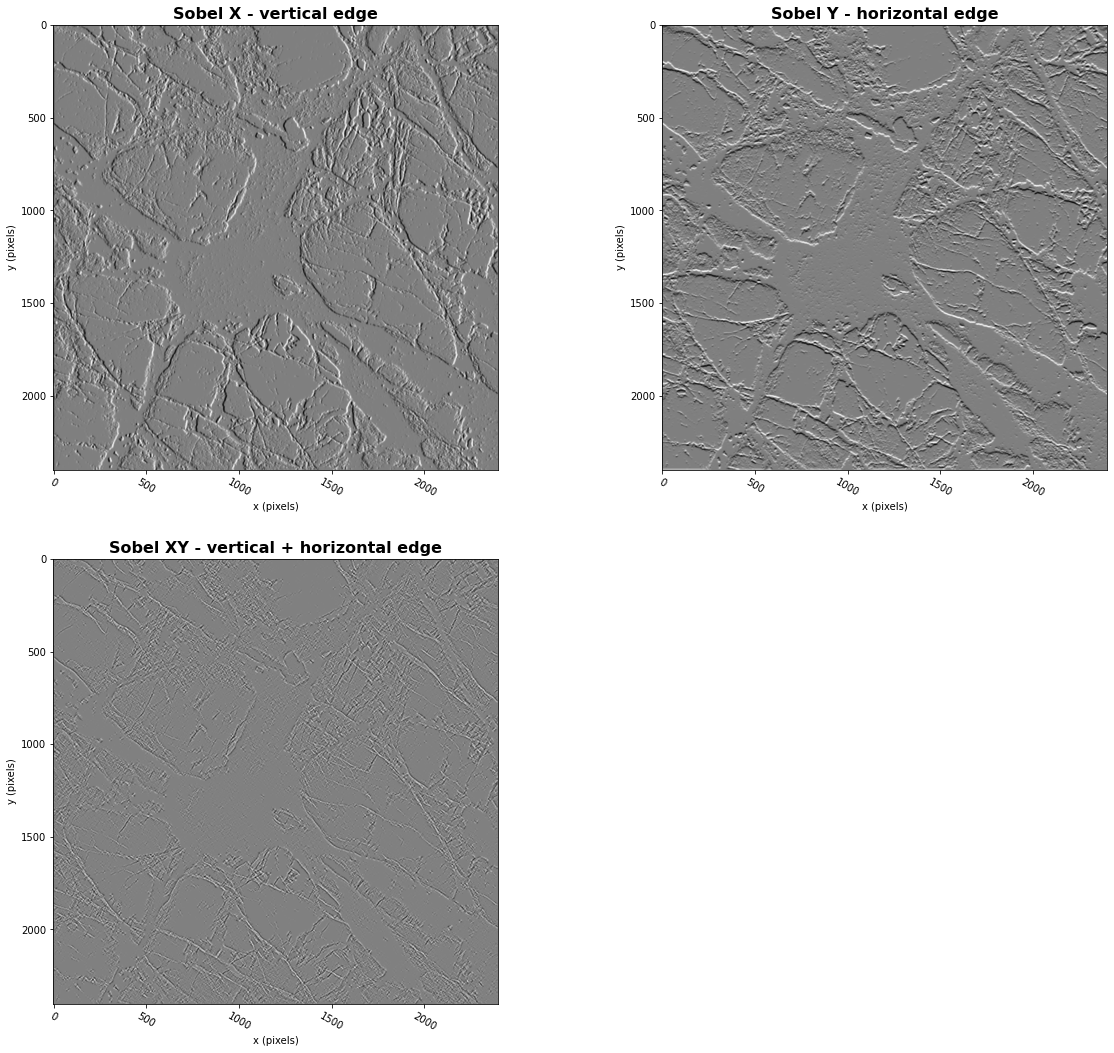

In [96]:
# Sobel Edge Detection with Blur 99
src=im_Blur99
sobelx = cv.Sobel(src, ddepth=cv.CV_64F, dx=1, dy=0, ksize=5) # Sobel Edge Detection on the X axis
sobely = cv.Sobel(src, ddepth=cv.CV_64F, dx=0, dy=1, ksize=5) # Sobel Edge Detection on the Y axis
sobelxy = cv.Sobel(src, ddepth=cv.CV_64F, dx=1, dy=1, ksize=5) # Combined X and Y Sobel Edge Detection
# Display Sobel Edge Detection Images
plt.figure(figsize=([20, 18]))
plt.subplot(221),plt.imshow(sobelx, cmap = 'gray')
plt.title('Sobel X - vertical edge', size=16,fontweight="bold"), 
plt.xlabel('x (pixels)',size=10)
plt.ylabel('y (pixels)',size=10)
plt.xticks(np.arange(0, 2400+1, step=500),rotation='-30')
plt.yticks(np.arange(0, 2400+1, step=500),rotation='  0')

plt.subplot(222),plt.imshow(sobely, cmap = 'gray')
plt.title('Sobel Y - horizontal edge', size=16,fontweight="bold"), 
plt.xlabel('x (pixels)',size=10)
plt.ylabel('y (pixels)',size=10)
plt.xticks(np.arange(0, 2400+1, step=500),rotation='-30')
plt.yticks(np.arange(0, 2400+1, step=500),rotation='  0')

plt.subplot(223),plt.imshow(sobelxy, cmap = 'gray')
plt.title('Sobel XY - vertical + horizontal edge', size=16,fontweight="bold"), 
plt.xlabel('x (pixels)',size=10)
plt.ylabel('y (pixels)',size=10)
plt.xticks(np.arange(0, 2400+1, step=500),rotation='-30')
plt.yticks(np.arange(0, 2400+1, step=500),rotation='  0')

#Plot Gradient Magnitude from SOBEL

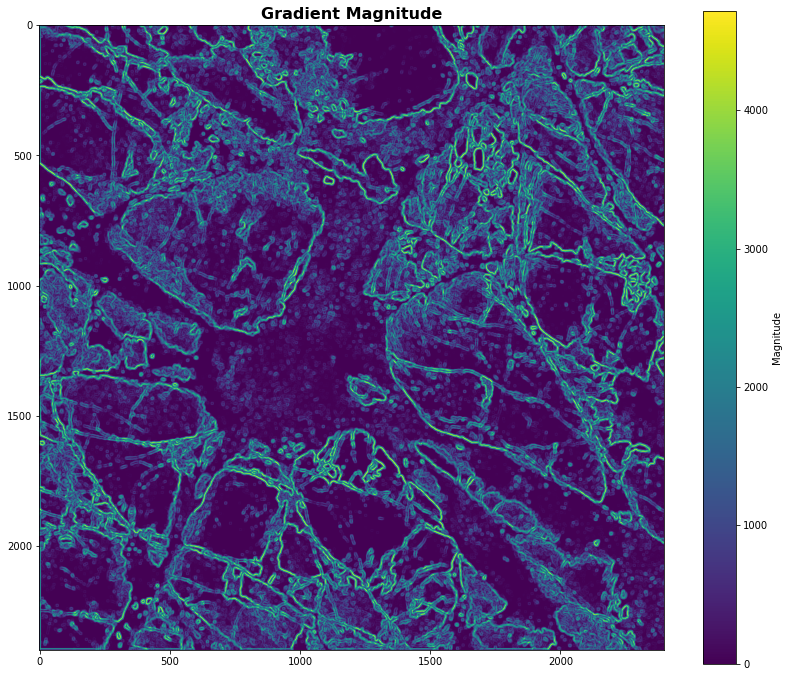

In [97]:
gradient_magnitude = np.sqrt(np.square(sobelx) + np.square(sobely))

plt.figure(figsize=([14, 12]))
imshow(gradient_magnitude)
plt.title("Gradient Magnitude",size=16,fontweight="bold")
cbar = plt.colorbar(label='Magnitude')
cbar.draw_all()
#plt.subplot(111),plt.imshow(gradient_magnitude)

## Preparation for Canny edge detection
Canny requires uint8 picture format as input.


In [98]:
print(ortho_contrast.dtype)
# Check the height of image 
print(ortho_contrast.shape[0])
# Check the width of image 
print(ortho_contrast.shape[1])

print(im_Blur2121.dtype)
# Check the height of image 
print(im_Blur2121.shape[0])
# Check the width of image 
print(im_Blur2121.shape[1])

print(im_Blur2121_Multi.dtype)
# Check the height of image 
print(im_Blur2121_Multi.shape[0])
# Check the width of image 
print(im_Blur2121_Multi.shape[1])

float32
2400
2400
uint8
2400
2400
uint8
2400
2400


In [99]:
img_raw_unit8 = (ortho_contrast*255).astype(np.uint8)
img_raw_blur = cv.GaussianBlur(img_raw_unit8,(9,9),5)

In [100]:
sobelxy_unit8 = (sobelxy*255).astype(np.uint8)
sobelxy_blur = cv.GaussianBlur(sobelxy_unit8,(9,9),5)

In [101]:
sobelx_unit8 = (sobelx*255).astype(np.uint32)
sobely_unit8 = (sobely*255).astype(np.uint32)

In [102]:
gradient_unit8 = (gradient_magnitude*255).astype(np.uint8)
gradient_blur = cv.GaussianBlur(gradient_unit8,(9,9),5)

In [103]:
#conv = imshow(ims_convolves[2],  cmap='gray')
conv_unit8 = (ims_convolves[1]*255).astype(np.uint8)
conv_blur = cv.GaussianBlur(conv_unit8,(9,9),5)

In [104]:
### ORIGIONAL IMAGE
image0 = img_raw_unit8 # HAS TO BE UNIT8 format and numpy.narray

image1 = img_raw_blur # HAS TO BE UNIT8 format and numpy.narray

### BLURRED IMAGE 55 Kernel
image2 = im_Blur55 # HAS TO BE UNIT8 format and numpy.narray

### BLURRED IMAGE 99 Kernel
image3 = im_Blur99 # HAS TO BE UNIT8 format and numpy.narray

### BLURRED IMAGE 1515 Kernel
image4 = im_Blur1515 # HAS TO BE UNIT8 format and numpy.narray

### BLURRED IMAGE 2121 Kernel
image5 = im_Blur2121 # HAS TO BE UNIT8 format and numpy.narray

### Gradient IMAGE 99 Kernel
image6 = gradient_blur # HAS TO BE UNIT8 format and numpy.narray

### Sobelxy
image7 = sobelxy_unit8 # HAS TO BE UNIT8 format and numpy.narray

### Sobel xy blurred
image8 = sobelxy_blur # HAS TO BE UNIT8 format and numpy.narray

### BLURRED IMAGE from CNN
image9 = conv_unit8 # HAS TO BE UNIT8 format and numpy.narray

### BLURRED IMAGE from CNN
image10 = conv_blur # HAS TO BE UNIT8 format and numpy.narray

### Blurred image of Multidirectional hillshade
image11 = im_Blur1515_Multi

### Blurred image of Multidirectional hillshade
image12 = im_Blur2121_Multi 

-1

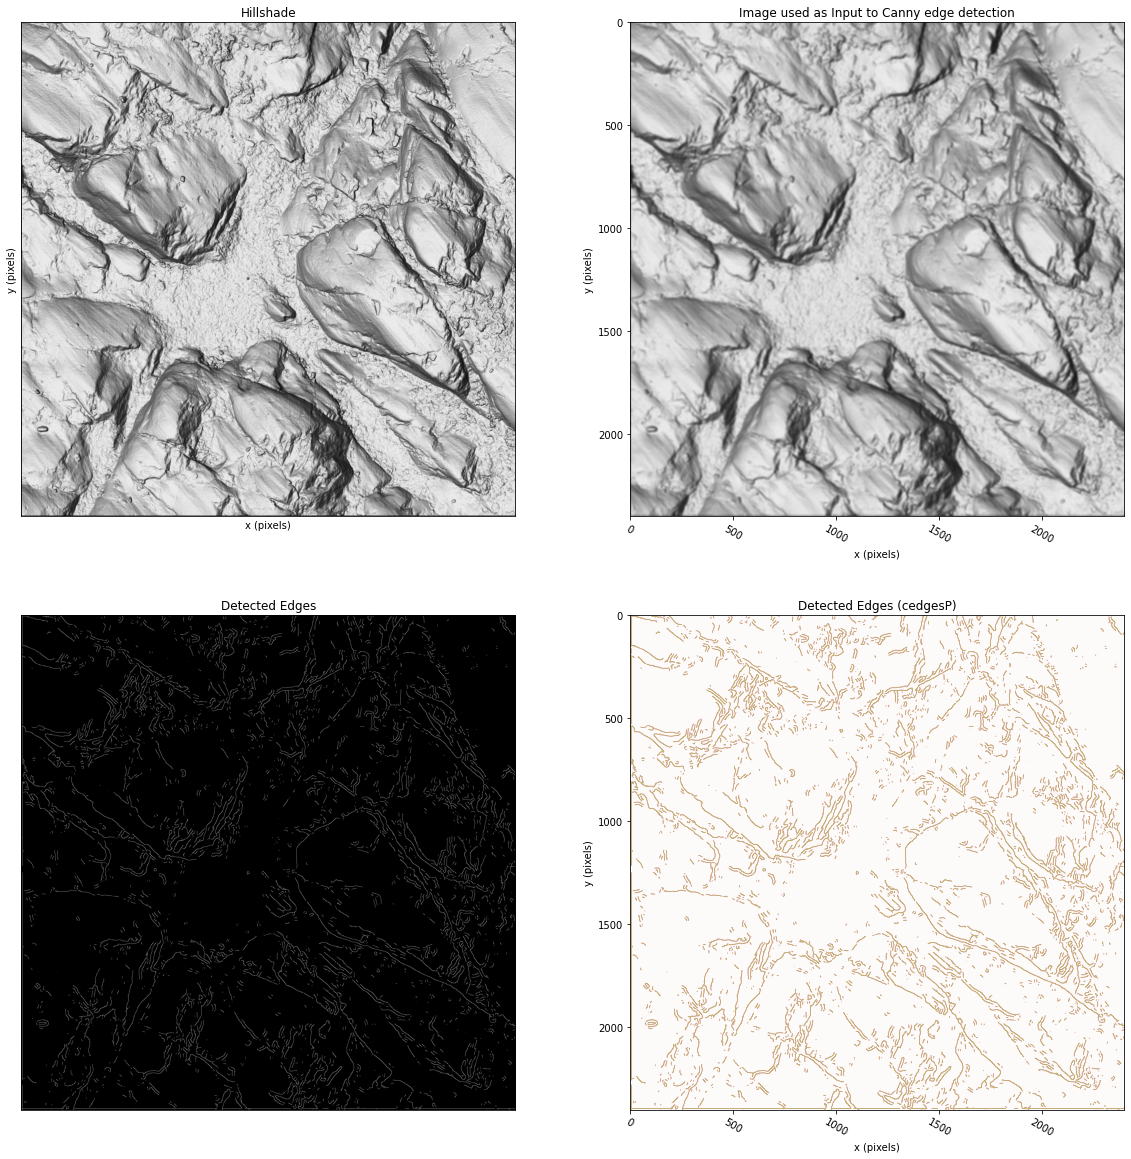

In [105]:
threshold1=49   #PLAY WITH THIS Parameter for optimal results
threshold2=50   #PLAY WITH THIS Parameter for optimal results

#### CHOOSE HERE WHICH FILTERED IMAGE IS INPUT  for Canny Edge detection: image1, image2, image3, image4
image=image11  
#Since edge detection is susceptible to noise in the image, Noise-reduced pictures seem to perform better, 
#hence we focus on the image with a Gaussian filter.

edges = cv.Canny(image=image, threshold1=threshold1, threshold2=threshold2, apertureSize=3, L2gradient=True ) # Canny Edge Detection

# Copy edges to the images that will display the results in BGR
cedges = cv.cvtColor(edges, cv.COLOR_GRAY2BGR)
cedgesP = np.copy(cedges) # Inverse color
# Display Canny Edge Detection Image
#f, axs = plt.subplots(2,1,figsize=(30,20))

phys_coords = [0, 2400, 0, 2400]
#plt.subplot(211)
fig = plt.subplots(2,2,figsize=(20,20))
plt.subplot(221),plt.imshow(Hillsh_Multi,extent=phys_coords)
plt.xlabel('x (pixels)',size=10)
plt.ylabel('y (pixels)',size=10)
plt.xticks(np.arange(0, 2400+1, step=500),rotation='-30')
plt.yticks(np.arange(0, 2400+1, step=500),rotation='  0')
plt.clim(500, 3000)
plt.xlabel('x (pixels)',size=10)
plt.ylabel('y (pixels)',size=10)
plt.xticks(np.arange(0, 2400+1, step=500),rotation='-30')
plt.yticks(np.arange(0, 2400+1, step=500),rotation='  0')
plt.title('Hillshade'), plt.xticks([]), plt.yticks([])


plt.subplot(222),plt.imshow(image, cmap = 'gray')
plt.title('Image used as Input to Canny edge detection'), plt.xticks([]), plt.yticks([])
plt.xlabel('x (pixels)',size=10)
plt.ylabel('y (pixels)',size=10)
plt.xticks(np.arange(0, 2400+1, step=500),rotation='-30')
plt.yticks(np.arange(0, 2400+1, step=500),rotation='  0')

plt.subplot(223),plt.imshow(cedges, cmap='gist_earth')
plt.title('Detected Edges'), plt.xticks([]), plt.yticks([])

segm_width = 1
alpha_val  = .9
plt.subplot(224),plt.imshow(edges, cmap='gist_earth_r', alpha=alpha_val)
#imshow(Hillsh_Multi)
plt.title('Detected Edges (cedgesP)')
plt.xlabel('x (pixels)',size=10)
plt.ylabel('y (pixels)',size=10)
plt.xticks(np.arange(0, 2400+1, step=500),rotation='-30')
plt.yticks(np.arange(0, 2400+1, step=500),rotation='  0')

cv.waitKey(0)


([<matplotlib.axis.YTick at 0x7f7619fdaf10>,
 <a list of 5 Text major ticklabel objects>)

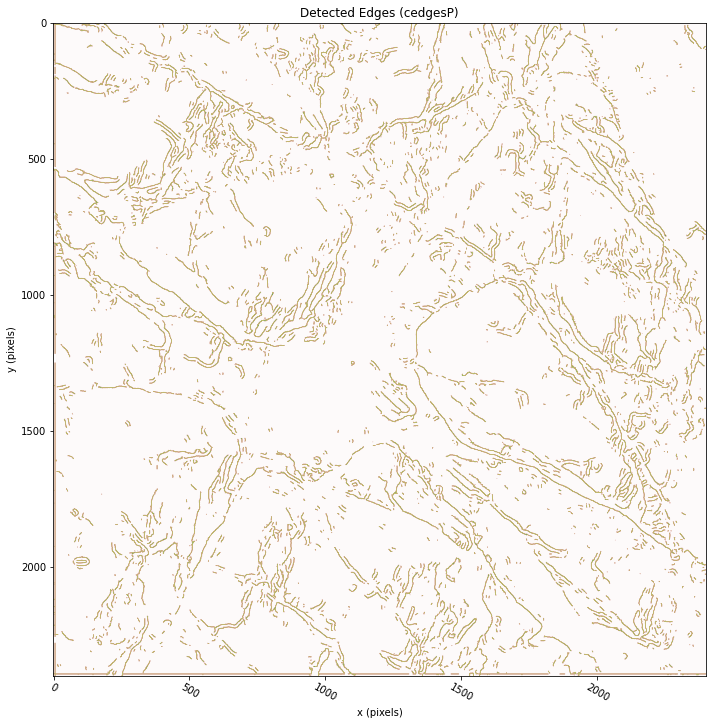

In [106]:
segm_width = 1
alpha_val  = .9

plt.figure(figsize=([14, 12]))
plt.imshow(edges, cmap='gist_earth_r', alpha=alpha_val)
#imshow(Hillsh_Multi)
plt.title('Detected Edges (cedgesP)')
plt.xlabel('x (pixels)',size=10)
plt.ylabel('y (pixels)',size=10)
plt.xticks(np.arange(0, 2400+1, step=500),rotation='-30')
plt.yticks(np.arange(0, 2400+1, step=500),rotation='  0')

In [107]:
cedgesP.shape

(2400, 2400, 3)

#Probilistic Hough Line Transform
- rho=1 # perpendicular distance from origin to the line theta=1*np.pi/180 # search angle, ideally 1 for 1 degree 
- threshold=10 # minimum vote it should get for it to be considered as a line. So it represents the minimum length of line that should be detected. 
- minLineLength=100 # Minimum length of line. Line segments shorter than this are rejected. 
- maxLineGap=1 # Maximum allowed gap between line segments to treat them as single line.

linesP = cv.HoughLinesP(edges,rho,theta,threshold,minLineLength,maxLineGap) for x1,y1,x2,y2 in linesP[0]: cv.line(cedgesP,(x1,y1),(x2,y2),(0,255,0),2)

np.shape(linesP)

In [108]:
threshold=10
minLineLength=18
maxLineGap=6

linesP = cv.HoughLinesP(edges,rho=0.5,theta=0.5*np.pi/180,threshold=threshold,minLineLength=minLineLength,maxLineGap=maxLineGap) # Max line Gap very sensitive, used to reduce amount of lineaments and merge them
for x1,y1,x2,y2 in linesP[0]:
    cv.line(cedgesP,(x1,y1),(x2,y2),(0,255,0),2)

#MAXLineGap 20 for BLurr1515 (image4)
#MaxLineGap 5 for Blurr 99 (image3)
#MaxLineGap 3 for Blurr55 (image2)
#MaxLineGap 3 for Original (image1)

In [109]:
linesP_n=np.reshape(linesP[:,:],[len(linesP),4])

In [110]:
linesP_n.shape

(815, 4)

In [111]:
# Lineaments detected with edge and Hough assigned to coordinates and put in list
df_lin = pd.DataFrame(linesP_n[:,:], columns = ['x1','y1','x2','y2'])
print(df_lin)

       x1    y1    x2    y2
0     255  2392   949  2392
1       7  2255     7  1248
2    1948  1306  1970  1343
3    1741  2155  1763  2177
4    1708  1834  1722  1854
..    ...   ...   ...   ...
810   503  1046   524  1061
811  2083  1730  2083  1712
812  1554   613  1555   593
813   160  1011   160   987
814     7   981     7   962

[815 rows x 4 columns]


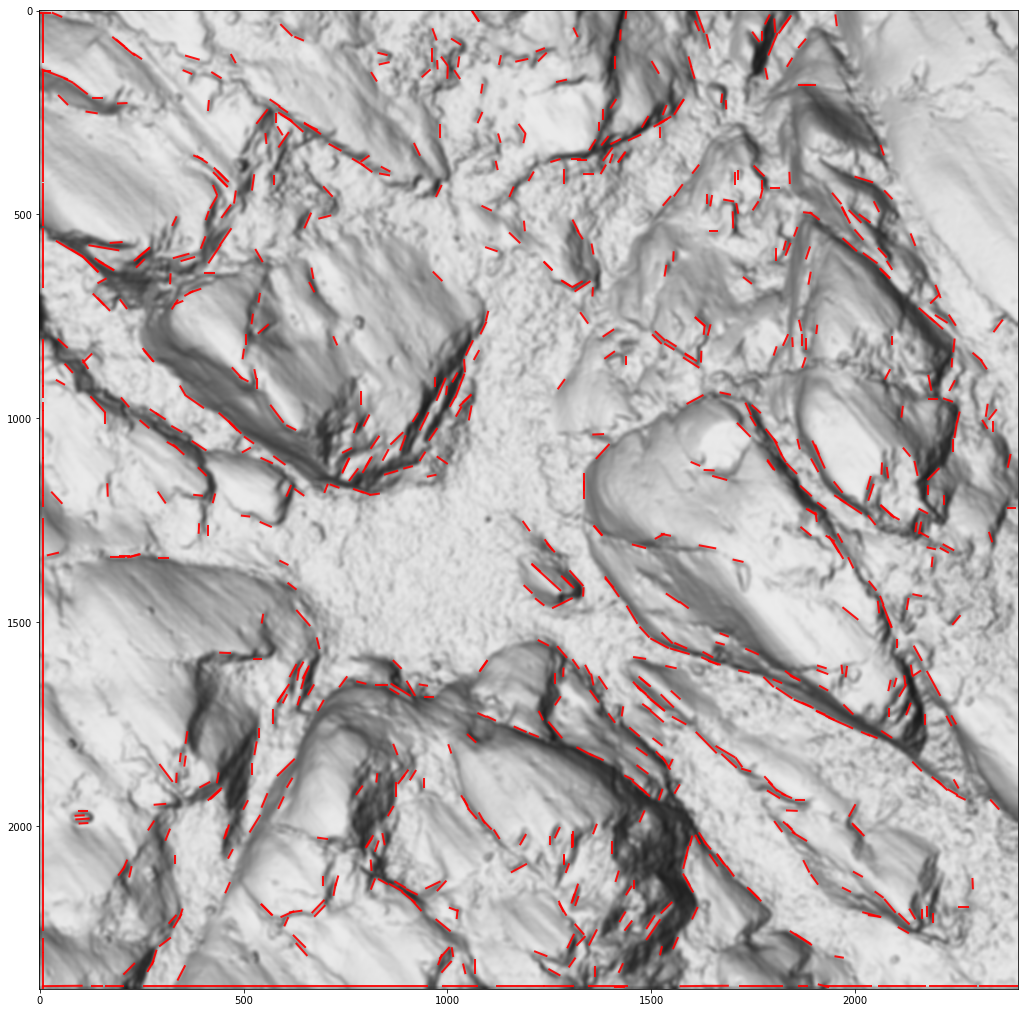

In [112]:
segm_width = 2
alpha_val  = .9

plt.figure(figsize=([20, 18]))
plt.plot((df_lin['x1'],df_lin['x2']), (df_lin['y1'],df_lin['y2']),color='red',alpha=alpha_val,linewidth=segm_width)
#axes.set_title("{}{}".format(index,degree))
imshow(image11, cmap = 'gray')

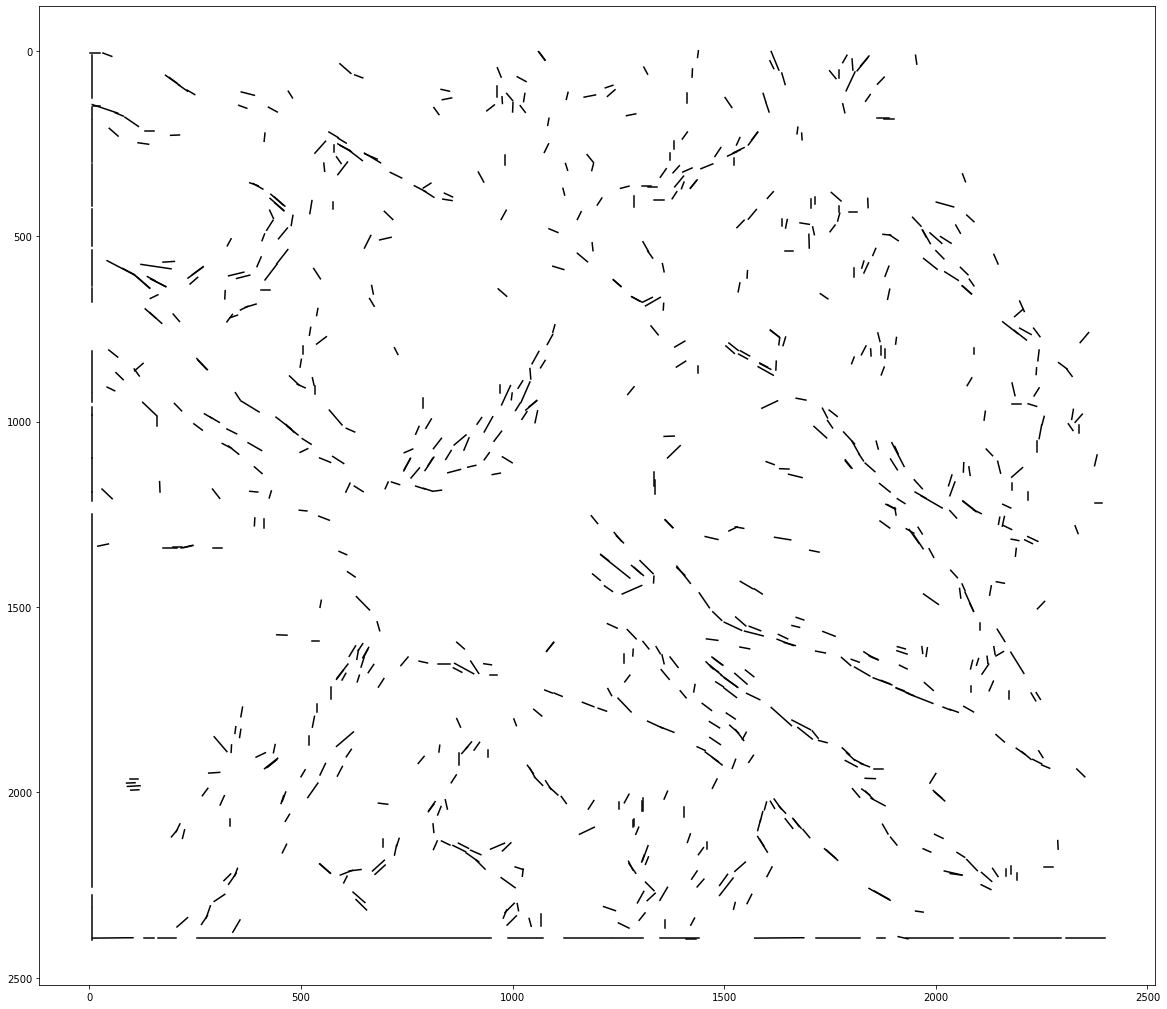

In [113]:
# Plot only predicted lineaments & export it to tiff
plt.figure(figsize=([20, 18]))
plt.plot((df_lin['x1'],df_lin['x2']), (df_lin['y1'],df_lin['y2']), color='black')
plt.gca().invert_yaxis()

from matplotlib import pyplot as plt

#saves images to drive
plt.savefig('/content/drive/MyDrive/Final_project_ADS/Image_Pred.tif') 

## Export Data to Google drive

In [114]:
# Store predicted lines and coordinate values to csv file in google drive
with open('/content/drive/MyDrive/CSV_tables/XX_image.csv', 'w') as f:
  fwriter = csv.writer(f,delimiter=';')

  for i in linesP:
      a = []
      for j in range(0,4,1):
        #print(i[0][j])
        a.append(i[0][j])
      fwriter.writerow(a)
      #print(np.shape(i))
      #break
  f.close()

# Read the csv table in with the reference dataset

In [115]:
# We load the reference dataset
df_list=[]
#path = "https://raw.githubusercontent.com/stfabbri/CAS_thesis/main/CSV_data_files/"
path="https://raw.githubusercontent.com/stfabbri/CAS_ADS_Thesis_final/main/CSV-OUTPUT/"
#path = "/content/drive/MyDrive/CSV_tables/"
name = "_REF.csv"
index=['Lineaments_in_perimeter_edit_yflipped']
for df_ in index:
    df_i = pd.read_csv("{}{}{}".format(path,df_,name),delimiter=';')
    df_list.append(df_i)

In [116]:
df_list[0] #Reference dataset

x1       y1       x2       y2
0      -67.406297  1365.36    34.80  1349.40
1        0.325532  1349.40   155.40  1334.16
2      155.400000  1334.16   317.40  1344.96
3      317.400000  1344.96   473.52  1360.92
4      473.520000  1360.92   602.52  1390.68
...           ...      ...      ...      ...
4684   475.800000   628.56   501.24   615.84
4685   505.680000   588.84   494.88   608.88
4686   447.240000   613.32   453.60   602.76
4687  2349.000000   252.96  2380.80   263.40
4688  2380.800000   263.40  2413.92   273.24

[4689 rows x 4 columns]

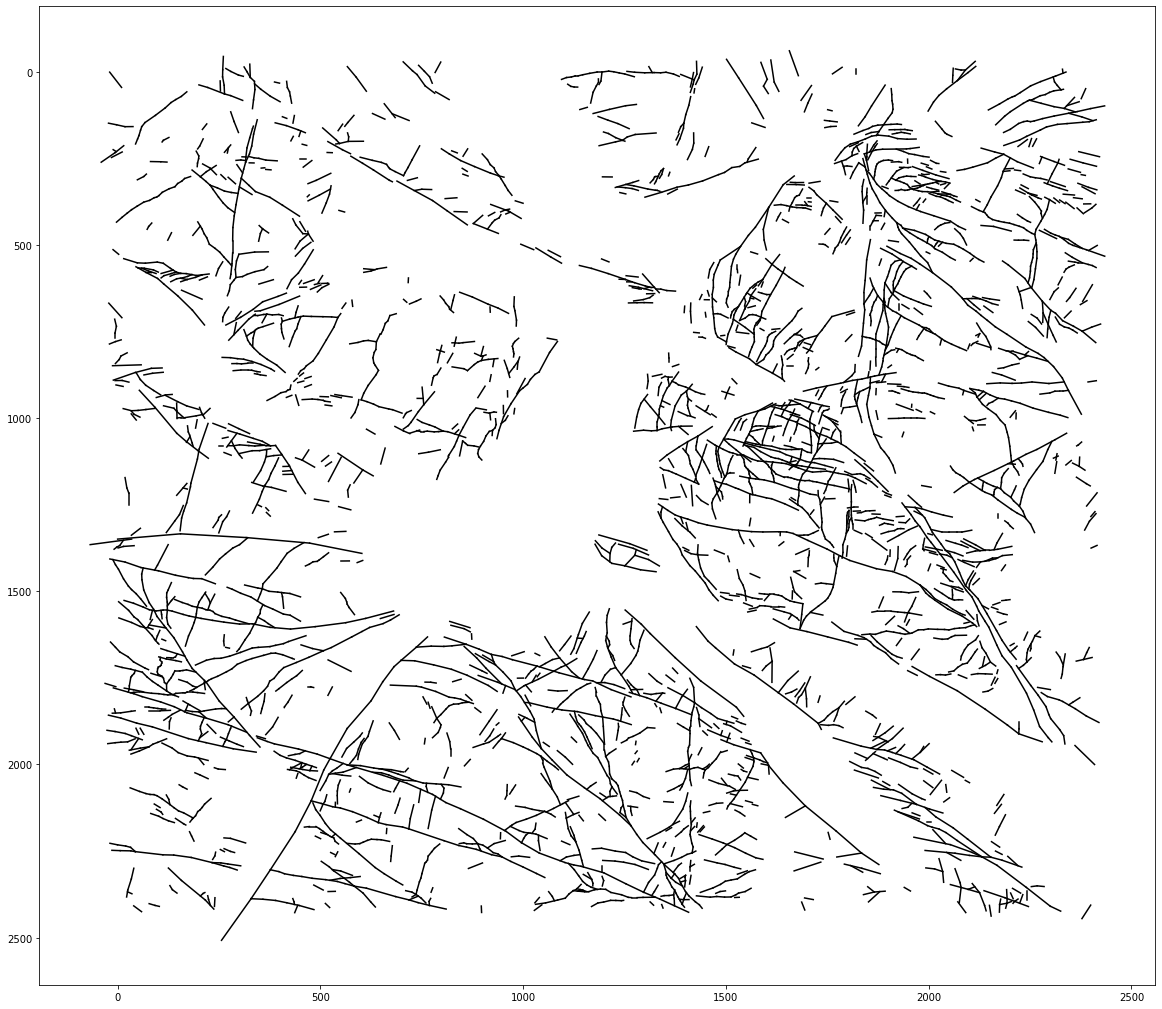

In [117]:
# Plot Ref dataset
plt.figure(figsize=([20, 18]))


plt.plot((df_list[0]['x1'],df_list[0]['x2']), (df_list[0]['y1'],df_list[0]['y2']), color='black')
plt.gca().invert_yaxis()
from matplotlib import pyplot as plt

# Saves image to drive
plt.savefig('/content/drive/MyDrive/Final_project_ADS/Image_Ref.tif') 

## Plot comparison of predicted and reference (true) data

In [118]:
plt.figure(figsize=([20, 18]))
p_ref = plt.plot((df_list[0]['x1'],df_list[0]['x2']), (df_list[0]['y1'],df_list[0]['y2']), color='yellow') # Ref

p_pred= plt.plot((df_lin['x1'],df_lin['x2']), (df_lin['y1'],df_lin['y2']), color='red') # pred
plt.title("Comparison_image_pred_vs_Ref",size=16,fontweight="bold")
#plt.gca().invert_yaxis()

imshow(Hillsh_Multi, cmap = 'gray')


Output hidden; open in https://colab.research.google.com to view.

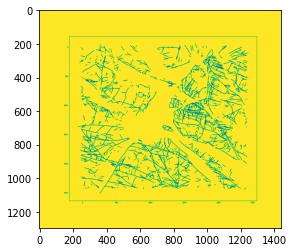

In [119]:
# produce Reference image
url_Image_Ref = 'https://github.com/stfabbri/CAS_ADS_Thesis_final/blob/main/INPUT_FIGURES/Image_Ref.tif?raw=true'

with urllib.request.urlopen(url_Image_Ref) as url:
  with open('Image_Ref.tif', 'wb') as f:
    f.write(url.read())
# Assign Name
y_true = mpimg.imread('Image_Ref.tif')
#Loading from drive
#y_true = mpimg.imread('/content/drive/MyDrive/Final_project_ADS/Image_ref.tif')

gray_y_true = cv.cvtColor(y_true, cv.COLOR_BGR2GRAY)

y_true_bw = cv.threshold(gray_y_true, 127, 255, cv.THRESH_BINARY) # Needs to be binary for jaccard score

y_true_bw = y_true_bw[1] # Eliminate first dimension

plt.imshow(y_true_bw)


#y_true = np.asarray(y_true, dtype=np.float32)

#y_true = y_true[y_true == 255] = 0


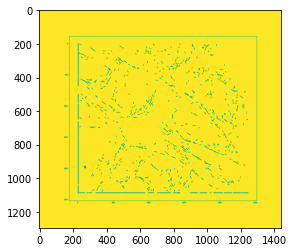

In [120]:
# produce predicted image
url_Image_Pred = 'https://github.com/stfabbri/CAS_ADS_Thesis_final/blob/main/INPUT_FIGURES/Image_Pred.tif?raw=true' # just one example

with urllib.request.urlopen(url_Image_Pred) as url:
  with open('Image_Pred.tif', 'wb') as f:
    f.write(url.read())
# Assign Name
y_pred =mpimg.imread('Image_Pred.tif')
#Loading from drive
#y_pred =mpimg.imread('/content/drive/MyDrive/Final_project_ADS/image112_pred.tif')

gray_y_pred = cv.cvtColor(y_pred, cv.COLOR_BGR2GRAY)

y_pred_bw = cv.threshold(gray_y_pred, 127, 255, cv.THRESH_BINARY)

y_pred_bw = y_pred_bw[1] # Eliminate first dimension

plt.imshow(y_pred_bw)

(array([[   0.,    0.,    0., ...,    0.,    0., 1296.],
        [   0.,    0.,    0., ...,    0.,    0., 1296.],
        [   0.,    0.,    0., ...,    0.,    0., 1296.],
        ...,
        [   0.,    0.,    0., ...,    0.,    0., 1296.],
        [   0.,    0.,    0., ...,    0.,    0., 1296.],
        [   0.,    0.,    0., ...,    0.,    0., 1296.]]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <a list of 1440 Lists of Patches objects>)

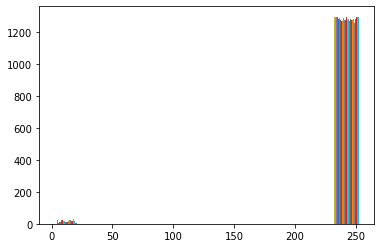

In [121]:
plt.hist(y_pred_bw) 

In [122]:
# make sure there are only zeros and once in array
ar=np.unique(y_pred_bw)
print(ar)

[  0 255]


## Compare prediction and reference dataset
Jaccard similarity coefficient score.

The Jaccard index, or Jaccard similarity coefficient, defined as the size of the intersection divided by the size of the union of two label sets, is used to compare set of predicted labels for a sample to the corresponding set of labels in y_true.

'micro':
Calculate metrics globally by counting the total true positives, false negatives and false positives.

'macro':
Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.

'weighted':
Calculate metrics for each label, and find their average, weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance.
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.jaccard_score.html


In [123]:
# jaccard score -> compare prediction with reference dataset
import numpy as np
from sklearn.metrics import jaccard_score

# jaccard requires binary input with values no lager than 1
y_true_bw1 = y_true_bw/255
y_pred_bw1 = y_pred_bw/255

score=jaccard_score(y_true_bw1,y_pred_bw1, average="micro")
print(np.round(score,5))

# Calculate metrics globally by counting the total true positives, false negatives and false positives.

0.95841


In [124]:
# Calculate all zeros, which indicate the pixels with lineament
n_zeros = np.count_nonzero(y_pred_bw1==0)
# display the count of zeros
print(n_zeros)

n_zeros_true = np.count_nonzero(y_true_bw1==0)
# display the count of zeros
print(n_zeros_true)

22105
66016


This graph plots the Hough Transform

Text(0, 0.5, 'Distance (pixels)')

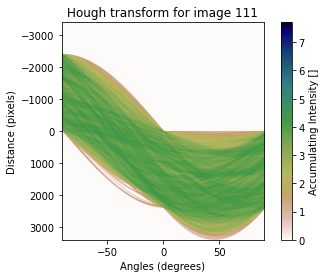

In [125]:
from skimage.transform import hough_line, hough_line_peaks
#from skimage.feature import canny
#from skimage.draw import line
from skimage import data

import matplotlib.pyplot as plt
from matplotlib import cm

# Classic straight-line Hough transform
# Set a precision of 0.5 degree.

fig = plt.plot(figsize=(12,10))

tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint=False)
h, theta, d = hough_line(edges, theta=tested_angles)

angle_step = 1 * np.diff(theta).mean()
d_step = 1 * np.diff(d).mean()
bounds = [np.rad2deg(theta[0] - angle_step),
          np.rad2deg(theta[-1] + angle_step),
          d[-1] + d_step, d[0] - d_step]
imshow(np.log(1 + h), extent=bounds, cmap=cm.gist_earth_r, aspect=1 / 35.0)

plt.title('Hough transform for image 111')
cbar = plt.colorbar(label='Accumulating Intensity []')
plt.xlabel('Angles (degrees)')
plt.ylabel('Distance (pixels)')


In [126]:
# Merge single lines if needed
# NOT APPLIED in Thesis, since it needs more evaluation....
import cv2, numpy as np

kernel = np.ones((10,10), np.uint8)
d_im = cv2.dilate(cedgesP, kernel, iterations=1)
e_im = cv2.erode(d_im, kernel, iterations=1)

Reduce e_im by one dimension

In [127]:
e_im = e_im[:, :, 0]

In [128]:
e_im

array([[255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

(Text(0.5, 1.0, 'Detected Edges (cedgesP)'),
 ([], <a list of 0 Text major ticklabel objects>),
 ([], <a list of 0 Text major ticklabel objects>))

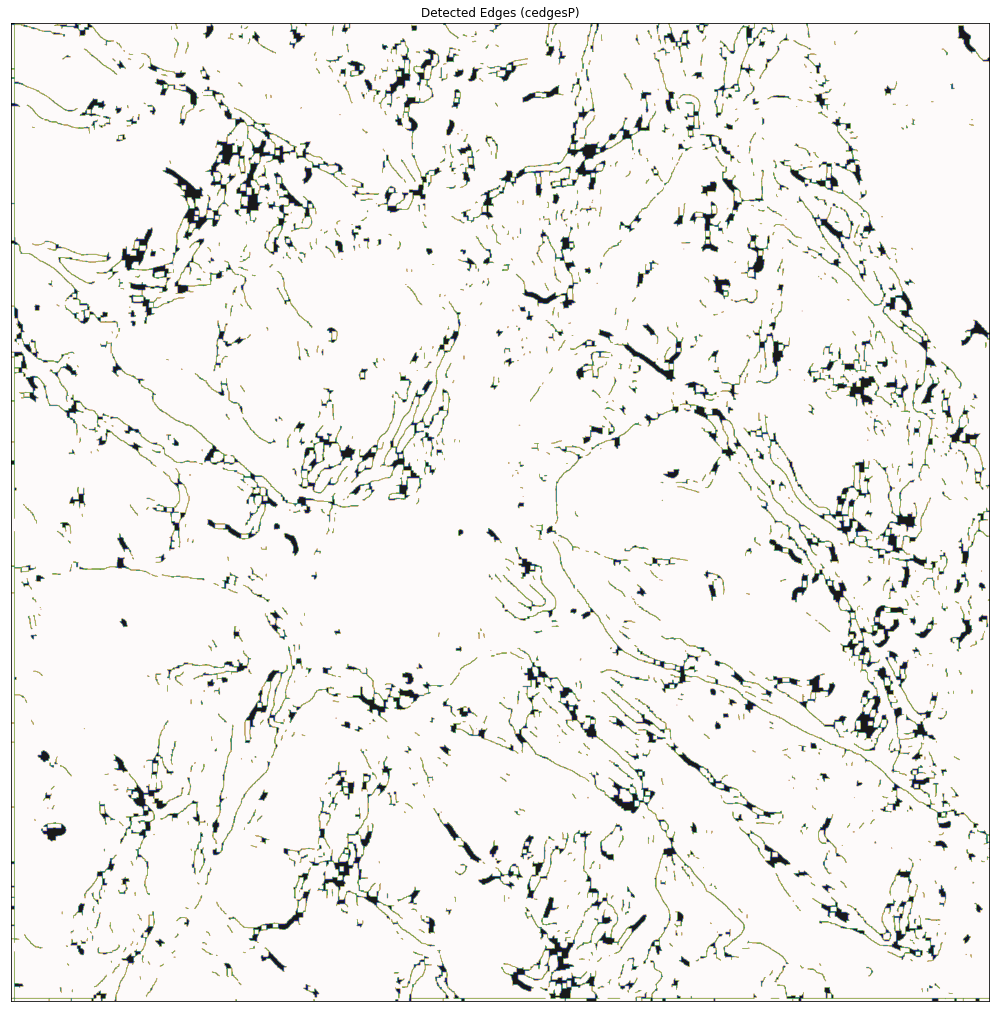

In [129]:
segm_width = 1
alpha_val  = .9

plt.figure(figsize=([20, 18]))
plt.imshow(e_im, cmap='gist_earth_r', alpha=alpha_val)
#imshow(Hillsh_Multi)
plt.title('Detected Edges (cedgesP)'), plt.xticks([]), plt.yticks([])